In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, RandomSampler
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

#assert torch.cuda.is_available()

# Problem 1
Download the CIFAR10 training and test datasets.
Transform them into tensors, normalize them as described above in the code, and create DataLoaders for each one. 
For the training set, use a batch size of 32, and for the test set, use a batch size of 1.

In [3]:
# Set the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Normalize data and transform it into a tensor
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download the CIFAR10 training and test datasets and create DataLoaders for each
train_data = datasets.CIFAR10('../data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

test_data = datasets.CIFAR10('../data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Get the 32 images of size 3x32x32 and labels in the first batch
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.to(device)

# Loop through the data for training
for batch, (x, y_truth) in enumerate(train_loader):
  x, y_truth = x.to(device), y_truth.to(device)

In [ ]:
images[0].type

<function Tensor.type>

In [5]:
classes = ('airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks')


# Problem 2

Create a convolution model class convoles an image of size $3\times 32 \times 32$ into a 1D tensor that represents the $10$ classes.
The model should have at least three convolution layers, each followed by an activation function, and include at least two linear layers and one maxpool layer.
Select channels and kernel sizes so that you get at least $50,000$ parameters.

Calculate and print the number of learnable parameters in your model.

Initialize your model and move it to the device.
Run the model on a single image to make sure there are no errors.


In [6]:
class ConvolutionModel(nn.Module):
  def __init__(self):
    super(ConvolutionModel, self).__init__()

    # Initialize the layers
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=2) #6x28x28
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=20, kernel_size=2) # 10x12x12
    self.conv3 = nn.Conv2d(in_channels=20, out_channels=25, kernel_size=2) # 15x9x9

    self.relu = nn.ReLU()# 6x28x28
    self.maxpool = nn.MaxPool2d(kernel_size=2) # 6x14x14
    self.flatten = nn.Flatten() # 1x(12*9*9)
    self.linear1 = nn.Linear(in_features=14, out_features=20)
    self.linear2 = nn.Linear(in_features=25 * 13 * 19, out_features=10)
  
  # Call the layers on an image
  def forward(self, x):
    output = self.relu(self.conv1(x)) #6x28x28
    output = self.maxpool(output) #6x14x14
    output = self.relu(self.conv2(output)) #15x12x12
    output = self.linear1(output) # 10x12x15
    output = self.relu(self.conv3(output)) #15x13x19
    output = self.flatten(output) #1x(15*3*19)
    return self.linear2(output) #1x10
          

In [7]:
# Instantiate the model
model = ConvolutionModel()

# set the model to the GPU if available
model = model.to(device)

# Apply the model to a single image
m = model(images[0].unsqueeze(0))

In [8]:
total_params = sum(p.numel() for p in model.parameters())
print('Total Parameters: ' + str(total_params))

Total Parameters: 64663


# Problem 3

Train the model by looping through the training data. Inside the loop, you should
1. Zero out the gradients.
2. Run the model on the inputs.
3. Calculate the loss on the model output and the actual label.
4. Backpropogate the error.
5. Optimize.

Run the loop for 10 epochs. At the end of each epoch, calculate the mean loss of the
training data for that epoch. Then calculate the accuracy of the model on the test data. Since
the model is no longer training, it needs to be set to evaluation mode using model.eval().
To resume training at the beginning of the next epoch, set the model to training mode using
model.train().

You should have around $50\%$ accuracy at the end of $10$ epochs.

Plot the epochs v. mean training loss each epoch and the epochs v. accuracy.


In [14]:
epochs = 10
epoch_losses = []
mean_losses = []
acc = []
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

"""for i in range(epochs):
  optimizer.zero_grad()             # Zero out the the gradients
  outputs = model(inputs)           # Run the model
  loss.append(objective(outputs, labels)) # Calculate loss
  loss.backward()                   # Compute gradients
  optimizer.step()                  # Optimize and update the weights

  # Update the progress bar
  loop.set_description('loss:{:.4f}'.format(loss[i].item()))
  loop.update()"""

for epoch in range(epochs):
  loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
  for batch_idx, (data, targets) in loop:
    # Get data to cude
    data = data.to(device)
    targets = targets.to(device)

    # Forward pass
    scores = model(data)
    loss = objective(scores, targets)
    e_loss = loss.detach().cpu().item()
    epoch_losses.append(e_loss)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Gradent descent or adam step
    optimizer.step()

    # Update progress bar
    loop.set_description(f'Epoch [{epoch}/{epochs}]')
    loop.set_postfix(loss=loss.item())
  
  # Calculate the mean loss of training data for the epoch
  #epoch_losses = epoch_losses.cpu()
  mean_losses.append(np.mean(epoch_losses))
  epoch_losses = []

  # Calculate the accuracy on the test data
  model.eval() # Set to evaluation mode
  correct = 0
  total = 0
  for batch, (x, y_truth) in enumerate(test_loader):
      x, y_truth = x.to(device), y_truth.to(device)
      outputs = model(x) # Run the model

      # pick the argmax class as prediction
      _, predicted = torch.max(outputs.data, 1)
      total += y_truth.size(0)
      correct += (predicted==y_truth).sum().item()
  
  acc.append(correct/total)
  model.train() # Set to training mode

        




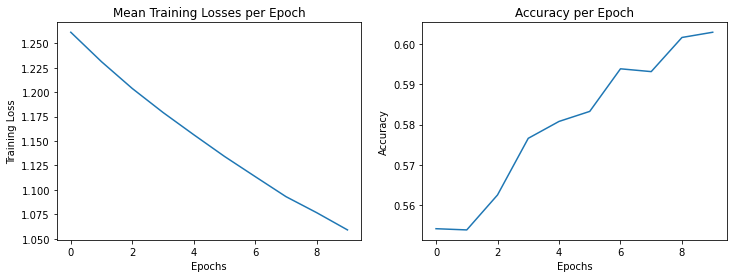

In [18]:
# Plot the training loss and accuracy
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(np.arange(epochs),mean_losses)
ax[0].set_title('Mean Training Losses per Epoch')
ax[0].set(xlabel='Epochs',ylabel='Training Loss')
ax[1].plot(np.arange(epochs),acc)
ax[1].set_title('Accuracy per Epoch')
ax[1].set(xlabel='Epochs',ylabel='Accuracy')
plt.show()

# Problem 4
Write a function that loops through the test data, modifying the images as described.
Run your function for each epsilon in $[0,.05,.1,.15,.2,.25,.3]$, and plot epsilon v. accuracy.
Display the perturbed version of the first image in the test data for each epsilon.

In [23]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Return the perturbed image adding clipping to maintain [-1,1] range
    return torch.clamp(perturbed_image, 0, 1)

In [37]:
def adversarial_attack(model, test_loader, eps):
  # Initialize
  acc = []
  model.eval()
  
  for x, y in test_loader:
    x = x.to(device)
    y = y.to(device)
    x.requires_grad = True
    output = model(x)
    #if output != y:
      #continue

    loss = objective(output, y)
    optimizer.zero_grad()
    loss.backward()
    data_grad = x.grad.data
    perturbed_data = fgsm_attack(x, eps, data_grad)
    output = model(perturbed_data)

  # Calculate the accuracy
  correct = 0
  total = 0
  for batch, (x, y_truth) in enumerate(test_loader):
      x, y_truth = x.to(device), y_truth.to(device)
      outputs = model(x) # Run the model

      # pick the argmax class as prediction
      _, predicted = torch.max(outputs.data, 1)
      total += y_truth.size(0)
      correct += (predicted==y_truth).sum().item()
  
  acc.append(correct/total)

  return acc, perturbed_data


In [38]:
accuracy = []
p_data = []
for eps in [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
  acc, perturbed_data = adversarial_attack(model, test_loader, eps)
  accuracy.append(acc)
  p_data.append(perturbed_data)

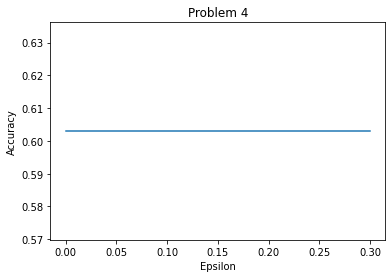

In [64]:
# Plot epsilon v accuracy
plt.plot([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3], accuracy)
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Problem 4')
plt.show()

In [61]:
#for i in range(4,len(p_data)):
  #p_data[i] = p_data[i].squeeze().detach().cpu().numpy()


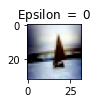

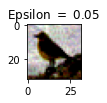

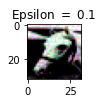

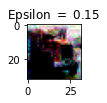

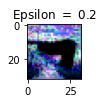

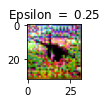

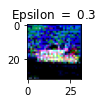

In [60]:
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

for i in range(len(epsilons)):
  fig = plt.figure(figsize=(1,1))
  plt.imshow(np.transpose(p_data[i],(1,2,0)))
  plt.title('Epsilon $=$ ' + str(epsilons[i]))
  plt.show()